# XGBoost - Predicción usando dataset_final
Este notebook carga `data/dataset_final.csv`
De todos los modelos, XGBoost fue el que nos dio mejores resultados junto a random forest, entonces decidimos hacer la tarea de entrenamiento de 7 modelos distintos, uno para predecir cada dia, con este modelo.
Lo que hacemos con el dataset importado, que unía todas nuestras features, es calcularle un shift según el día que prediga cada modelo para ir cambiando el target que tendrá cada uno.

Un ejemplo:

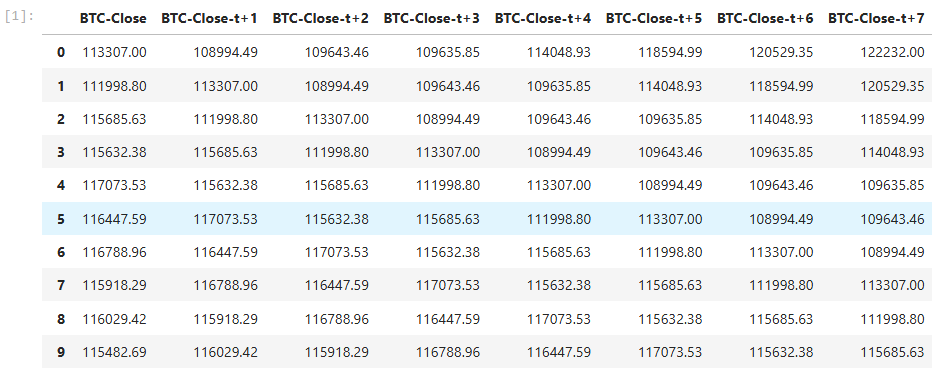

La columna 9 tiene su propio BTC-Close, BTC-Close-t+1 es el precio del día siguiente, osea, el BTC-Close de la columna 8, BTC-Close-t+2 es el precio del día siguiente al día siguiente (pasado mañana si lo vemos como hoy), que es el BTC-Close de la columna 7, y así sucesivamente.
Cada modelo aprenderá a predecir un target distinto de estos, siendo ese target el día a predecir.

In [1]:
from pathlib import Path
import pandas as pd

# Ruta del dataset procesado
data_dir = Path.cwd().parent.parent / "data"
df = pd.read_csv(data_dir / "dataset_final.csv")

# Crear targets desplazados para los próximos 7 días
for i in range(1, 8):
    df[f"BTC-Close-t+{i}"] = df["BTC-Close"].shift(i)

# Eliminar filas con NaN generadas por los shifts (últimos registros)
df = df.dropna().reset_index(drop=True)

df[['BTC-Close', 'BTC-Close-t+1','BTC-Close-t+2','BTC-Close-t+3','BTC-Close-t+4','BTC-Close-t+5','BTC-Close-t+6','BTC-Close-t+7']].head(20)

,BTC-Close,BTC-Close-t+1,BTC-Close-t+2,BTC-Close-t+3,BTC-Close-t+4,BTC-Close-t+5,BTC-Close-t+6,BTC-Close-t+7
0,113307.00,108994.49,109643.46,109635.85,114048.93,118594.99,120529.35,122232.00
1,111998.80,113307.00,108994.49,109643.46,109635.85,114048.93,118594.99,120529.35
2,115685.63,111998.80,113307.00,108994.49,109643.46,109635.85,114048.93,118594.99
3,115632.38,115685.63,111998.80,113307.00,108994.49,109643.46,109635.85,114048.93
4,117073.53,115632.38,115685.63,111998.80,113307.00,108994.49,109643.46,109635.85
5,116447.59,117073.53,115632.38,115685.63,111998.80,113307.00,108994.49,109643.46
6,116788.96,116447.59,117073.53,115632.38,115685.63,111998.80,113307.00,108994.49
7,115918.29,116788.96,116447.59,117073.53,115632.38,115685.63,111998.80,113307.00
8,116029.42,115918.29,116788.96,116447.59,117073.53,115632.38,115685.63,111998.80
9,115482.69,116029.42,115918.29,116788.96,116447.59,117073.53,115632.38,115685.63


In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

models = {}
results = {}

for i in range(1, 8):
    TARGET = f"BTC-Close-t+{i}"
    X = df.drop(columns=[f"BTC-Close-t+{j}" for j in range(1, 8)])  
    y = df[TARGET]

    # Split 70/15/15 sin shuffle para respetar temporalidad
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=False
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
    )

    model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.5,
    reg_alpha=0.5,
    min_child_weight=3,
    random_state=42,
    eval_metric="mae"
    )

    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    results[TARGET] = {
        "MAE-VAL": mae_val,
        "R2-VAL": r2_val,
        "MAE-TEST": mae_test,
        "R2-TEST": r2_test
    }
    models[TARGET] = model


In [3]:
for target, metrics in results.items():
    print(f"\n📊 RESULTS FOR {target}")
    print(f"  MAE (VAL):  {metrics['MAE-VAL']:.4f}")
    print(f"  R2  (VAL):  {metrics['R2-VAL']:.4f}")
    print(f"  MAE (TEST): {metrics['MAE-TEST']:.4f}")
    print(f"  R2  (TEST): {metrics['R2-TEST']:.4f}")


📊 RESULTS FOR BTC-Close-t+1
  MAE (VAL):  1556.4818
  R2  (VAL):  0.3216
  MAE (TEST): 1154.7441
  R2  (TEST): 0.7332

📊 RESULTS FOR BTC-Close-t+2
  MAE (VAL):  1586.4242
  R2  (VAL):  0.3336
  MAE (TEST): 1368.2676
  R2  (TEST): 0.6783

📊 RESULTS FOR BTC-Close-t+3
  MAE (VAL):  1342.0398
  R2  (VAL):  0.5422
  MAE (TEST): 869.6284
  R2  (TEST): 0.8291

📊 RESULTS FOR BTC-Close-t+4
  MAE (VAL):  1363.8000
  R2  (VAL):  0.4872
  MAE (TEST): 986.2255
  R2  (TEST): 0.7624

📊 RESULTS FOR BTC-Close-t+5
  MAE (VAL):  1384.1601
  R2  (VAL):  0.4722
  MAE (TEST): 1003.9632
  R2  (TEST): 0.7603

📊 RESULTS FOR BTC-Close-t+6
  MAE (VAL):  1544.1409
  R2  (VAL):  0.3605
  MAE (TEST): 1233.2675
  R2  (TEST): 0.6858

📊 RESULTS FOR BTC-Close-t+7
  MAE (VAL):  1722.3191
  R2  (VAL):  0.2430
  MAE (TEST): 1419.7884
  R2  (TEST): 0.6102
